In [1]:
import argparse
import os
import numpy as np
from skimage.io import imread, imsave
from skimage.transform import resize
from skimage import img_as_ubyte

from models.TwoHeadsNetwork import TwoHeadsNetwork

import torch
from torchvision import transforms
from torchvision.utils import make_grid
from utils.visualization import save_kernels_grid


In [2]:
opt = {
    'output_dir': 'testing_results',
    'gpu_id': 6,
    'gamma_factor': 2.2,
    'img' : './testing_imgs/0249.png',
    'model' : './TwoHeads.pkl'
}

In [3]:
K = 25 # number of elements en the base
blurry_image_filename = opt['img']
model_file = opt['model']

if not os.path.exists(opt['output_dir']):
    os.makedirs(opt['output_dir'])


img_name = blurry_image_filename.split('/')[-1]
img_name, ext = img_name.split('.')

print('loading image ',blurry_image_filename)
blurry_image = imread(blurry_image_filename)

loading image  ./testing_imgs/0249.png


In [4]:
two_heads = TwoHeadsNetwork(K).cuda(opt['gpu_id'])
print('loading weight\'s model')
two_heads.load_state_dict(torch.load(model_file, map_location='cuda:%d' % opt['gpu_id']))

two_heads.eval()

loading weight's model


TwoHeadsNetwork(
  (inc_rgb): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (inc_gray): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (down1): Down(
    (double_conv): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (down_sampling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): Down(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), pad

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])
blurry_tensor = transform(blurry_image).cuda(opt['gpu_id'])


In [6]:
transform = transforms.Compose([
    transforms.ToTensor()
])
blurry_tensor = transform(blurry_image).cuda(opt['gpu_id'])


In [7]:
blurry_tensor_to_compute_kernels = blurry_tensor**opt['gamma_factor'] - 0.5

In [8]:
kernels_estimated, masks_estimated = two_heads(blurry_tensor_to_compute_kernels[None,:,:,:])


In [9]:
kernels_estimated.shape

torch.Size([1, 25, 33, 33])

In [10]:
masks_estimated.shape

torch.Size([1, 25, 288, 288])

In [12]:
masks = masks_estimated.cpu().detach().numpy()

In [13]:
masks.shape

(1, 25, 288, 288)

In [14]:
all_masks = masks[0,:,:,:]
mask_sums = np.sum(all_masks, axis=(1, 2))
biggest_mask_index = np.argmax(mask_sums)
print(f'Biggest mask at : {biggest_mask_index}')


Biggest mask at : 2


In [15]:
x = masks[0,2,:,:]

In [16]:
x.shape

(288, 288)

In [17]:
np.min(x)

5.685982e-17

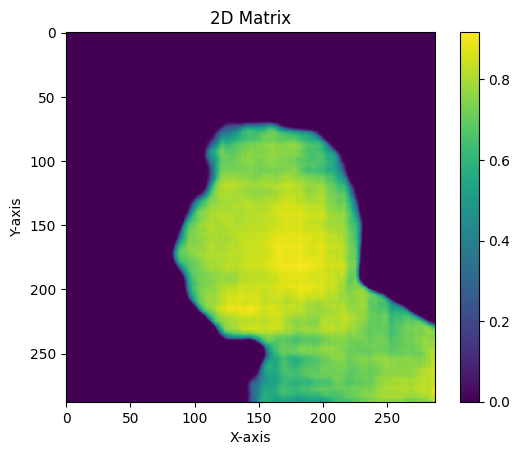

In [19]:
# Plot the matrix as an image using plt.imshow
import matplotlib.pyplot as plt

plt.imshow(x, cmap='viridis')  # You can choose a different colormap if you prefer
plt.colorbar()  # Add a colorbar to show the mapping of values to colors
plt.title("2D Matrix")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

In [21]:
filter = kernels_estimated[0,biggest_mask_index,:,:]

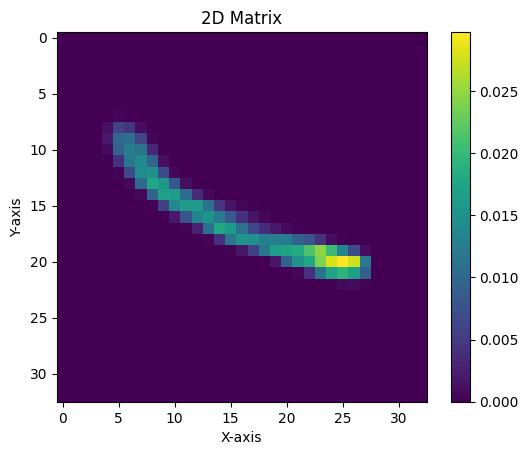

In [22]:
x = filter.detach().cpu().numpy()
plt.imshow(x, cmap='viridis')  # You can choose a different colormap if you prefer
plt.colorbar()  # Add a colorbar to show the mapping of values to colors
plt.title("2D Matrix")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

In [24]:
np.sum(x)

1.0

In [25]:
import numpy as np

def calculate_fwhm(kernel):
    # Step 1: Normalize the kernel
    normalized_kernel = kernel / np.sum(kernel)

    # Step 2: Find the maximum value and its location
    max_value = np.max(normalized_kernel)
    max_indices = np.unravel_index(np.argmax(normalized_kernel), kernel.shape)

    # Step 3: Compute the FWHM in row direction
    row_fwhm_left = 0
    for i in range(max_indices[0], -1, -1):
        if normalized_kernel[i, max_indices[1]] <= max_value / 2:
            break
        row_fwhm_left += 1

    row_fwhm_right = 0
    for i in range(max_indices[0], kernel.shape[0]):
        if normalized_kernel[i, max_indices[1]] <= max_value / 2:
            break
        row_fwhm_right += 1

    row_fwhm = row_fwhm_left + row_fwhm_right

    # Step 4: Compute the FWHM in column direction
    col_fwhm_up = 0
    for j in range(max_indices[1], -1, -1):
        if normalized_kernel[max_indices[0], j] <= max_value / 2:
            break
        col_fwhm_up += 1

    col_fwhm_down = 0
    for j in range(max_indices[1], kernel.shape[1]):
        if normalized_kernel[max_indices[0], j] <= max_value / 2:
            break
        col_fwhm_down += 1

    col_fwhm = col_fwhm_up + col_fwhm_down

    # Step 5: Average the FWHM values to get an overall measure
    overall_fwhm = (row_fwhm + col_fwhm) / 2.0
    return overall_fwhm

# Replace 'your_kernel' with the 2D numpy array representing the blur kernel


In [26]:
kernel_fwhm = calculate_fwhm(x)
print(f'kernel_fwhm : {kernel_fwhm}')

kernel_fwhm : 5.0
